# Installing and importing dependencies

In [1]:
!pip install openpyxl
!pip install pandas
!pip install numpy
!pip install rdkit

In [62]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from rdkit.Chem import DataStructs
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [255]:
#plt.style.use('science')
plt.style.reload_library() 

Function that will be used to check that no "na" values appear:

In [3]:
def check_no_na(data):
    if data.isna().sum().eq(0).all():
        print("Success: No NA values found.")
        return
    print("Warning: NA values found.")

# Importing the dataset

In [4]:
df_raw=pd.read_excel("denmark.xlsx")
df_raw.head()

,Catalyst,Imine,Thiol,Output
0,O=P1(O)OC2=C(C3=C(C4CCCCC4)C=C(C5CCCCC5)C=C3C6...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1C,3.134625
1,O=P1(O)OC2=C(C3=CC(C4=C(C)C=C(C)C=C4C)=CC(C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=C(OC)C=C1,1.531803
2,O=P1(O)OC2=C(C3=CC=C(OC)C=C3)C=C4C(C=CC=C4)=C2...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(Cl)C=C2Cl,SC1=CC=CC=C1,1.074991
3,O=P1(O)OC2=[C@]([C@]3=C(Cl)C=C(Cl)C=C3Cl)C=C4C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(OC)C=C2,SC1=CC=CC=C1C,1.334823
4,O=P1(O)OC2=C(C3=C(C=CC4=CC=CC(C=C5)=C46)C6=C5C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC3=C2C=CC=C3,SC1=CC=CC=C1,1.743658


# Looking at the data

### Target values

First of all, it would be important to look at how output values are distributed:

In [5]:
df_raw.describe()

,Output
count,1075.000000
mean,0.987658
std,0.700524
min,-0.419378
25%,0.473820
50%,1.050757
75%,1.370104
max,3.134625


One could also look at the distribution of the target variable:

In [256]:
plt.hist(x=df_raw["Output"], bins=20);
plt.title("Distribution of output values")
plt.xlabel("Ouput value");

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/giustino/.cache/matplotlib/tex.cache/6d4928c2d3a5434037f32bc4ea18dff4.te
x
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-01-09> xparse <2020-03-03>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 6d4928c2d3a5434037f32bc4ea18dff4.log.




<Figure size 252x189 with 1 Axes>

### Features

Are there any "na" values?

In [7]:
check_no_na(df_raw)

Success: No NA values found.


How many different molecules are there?

In [8]:
unique_catalysts=df_raw["Catalyst"].unique()
unique_imines=df_raw["Imine"].unique()
unique_thiols=df_raw["Thiol"].unique()
pd.DataFrame({"Unique Catalysts": [unique_catalysts.shape[0]], "Unique Imines": [unique_imines.shape[0]], "Unique Thiols": [unique_thiols.shape[0]]})

,Unique Catalysts,Unique Imines,Unique Thiols
0,43,5,5


Here, one could use One-hot encoding for the Imines and Thiols. This idea was discarded since in the case another Thiol or Imine is added, one would have to retrain the model instead of being able to fine-tune it. 

Show 3 random different Catalysts:

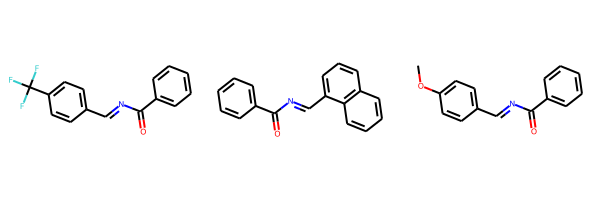

In [9]:
mol_list=[]
unique_molecules=df_raw["Imine"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Imine:

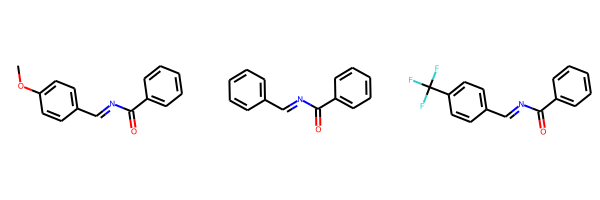

In [10]:
mol_list=[]
unique_molecules=df_raw["Imine"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules,index)
Draw.MolsToGridImage(mol_list)

Show 3 random different Thiol:

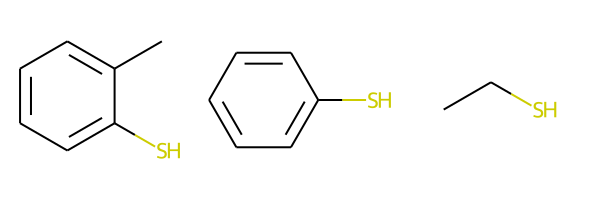

In [11]:
mol_list=[]
unique_molecules=df_raw["Thiol"].unique()
for i in range(3):
    index=np.random.randint(0, unique_molecules.shape[0])
    mol_list.append(Chem.MolFromSmiles(unique_molecules[index]))
    unique_molecules=np.delete(unique_molecules, index)
Draw.MolsToGridImage(mol_list)

# Preprocessing

### Creating RDKit molecules

Translating the "Catalyst", the "Imine" and the "Thiol" columns from SMILES to a RDKit molecule:

In [12]:
df_X=df_raw[["Catalyst", "Imine", "Thiol"]].applymap(Chem.MolFromSmiles)
df_y=df_raw["Output"]
df_X.head()

,Catalyst,Imine,Thiol
0,<rdkit.Chem.rdchem.Mol object at 0x7f1783e72490>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e729e0>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e0f670>
1,<rdkit.Chem.rdchem.Mol object at 0x7f1783e72bc0>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e72990>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e0f5d0>
2,<rdkit.Chem.rdchem.Mol object at 0x7f1783e72d50>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e0f580>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e24df0>
3,<rdkit.Chem.rdchem.Mol object at 0x7f1783e72da0>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e0f530>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e24da0>
4,<rdkit.Chem.rdchem.Mol object at 0x7f1783e72df0>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e0f6c0>,<rdkit.Chem.rdchem.Mol object at 0x7f1783e24d50>


Verifying that all the smiles transfered successfuly. The RDKit documentaton states:

>or None on failure:
>
>> ```m = Chem.MolFromMolFile('data/invalid.mol')```
>>
>> ```m is None```
>
>True

So the "na" instances are counted and should be 0 if no problems were encountered:

In [15]:
check_no_na(df_X)

Success: No NA values found.


For later on, Morgan fingerprints will be used. In order to try and search for the best parameters for these molecules, the atom radius and the number of bits used will be searched using grid search.

# Ridge regression

### Pipeline

Here, in order to later use SKlearn's ```CVGridSearch```, a custom pipeline will be built in order to be able to find the ideal hyperparameters. First step: creating a custom transformer to be used in the pipeline, in order to use RDKit's ```GetMorganFingerprint```'s parameters as hyperparameters for the model.

A similar pipeline template will be used for later trials, using the same functions. Although it is intuitive to assume that the same fingerprint parameters should be used for every model, the ```n_bits``` and the ```n_atom``` hyperparameters should be computed in order to verify that this hypothesis holds for different models.

Personal note: As this is the first time I work with molecules, my first thought was to build a simple ridge regressor and try to give it a morgan fingerprint as input. This is probably not viable since the number of parameters used is too great. Later on, the idea would be to add descriptors into the features, potentially using TF's functional API.

In [159]:
def morgan_fp(X, n_bits, n_atom):
    """Returns numpy array with bits from morgan fingerprint"""
    fp=AllChem.GetMorganFingerprintAsBitVect(X,int(n_atom), nBits=int(n_bits))
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

class fingerprinter(BaseEstimator, TransformerMixin):
    def __init__(self, n_bits=1024, n_atom=2):
        self.n_bits = n_bits # int necessary, otherwise rdkit c++ library doesn't play along
        self.n_atom = n_atom
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        new_X=np.array([])
        for row in X:
            new_row=np.array([])
            for element in row:
                fp=morgan_fp(element, self.n_bits, self.n_atom)
                new_row=np.append(new_row, fp, 0)
            #new_row=new_row.reshape((df_X.shape[1],-1))
            new_X=np.append(new_X, new_row)
            new_X=new_X.reshape([-1, new_row.shape[0]])
        return new_X
#fingerprinter([2,3,4][0], np.linspace(1000, 5000, 10, dtype=int)[0]).transform(X_train)

Now, the first pipeline can be created:

In [160]:
pipe = Pipeline([( "fingerprinter" , fingerprinter()),
                       ("ridge",Ridge())])

Parameter grid, to be fed into the grid search algorithm to find the optimal hyperparameters using cross-validation in order to reduce any biais that could be introduced by the shuffling.

In [205]:
#param_grid={"fingerprinter__n_bits":np.logspace(3, 4, 10, dtype=int), "fingerprinter__n_atom":np.arange(1, 4, 1), "ridge__alpha":np.logspace(0, 2, 4)}
#param_grid={"fingerprinter__n_bits": np.linspace(1000, 5000, 10, dtype=int), "fingerprinter__n_atom":np.array([2, 3, 4]), "ridge__alpha":np.logspace(-3, 1, 5)}
param_grid={"fingerprinter__n_bits": np.linspace(1500, 3000, 10, dtype=int), "fingerprinter__n_atom":np.array([2,3,4]), "ridge__alpha":np.logspace(-3, 3, 10)}
param_grid

{'fingerprinter__n_bits': array([1500, 1666, 1833, 2000, 2166, 2333, 2500, 2666, 2833, 3000]),
 'fingerprinter__n_atom': array([2, 3, 4]),
 'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
        4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
        2.15443469e+02, 1.00000000e+03])}

The train/test ratio was chosen arbitrarily. This could eventually be added as a hyperparameter to find an optimum as has been done [here](https://www.sciencedirect.com/science/article/pii/S2451929420300851). 

In [206]:
X_train, X_test, y_train, y_test=train_test_split(df_X.to_numpy(), df_y.to_numpy(), train_size=0.75)

The default cross-validation of 5-fold were chosen, as the available computational power is relatively low.

In [207]:
ridge_search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=3)
ridge_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(estimator=Pipeline(steps=[('fingerprinter', fingerprinter()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'fingerprinter__n_atom': array([2, 3, 4]),
                         'fingerprinter__n_bits': array([1500, 1666, 1833, 2000, 2166, 2333, 2500, 2666, 2833, 3000]),
                         'ridge__alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             verbose=3)

In [239]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",ridge_search.best_estimator_)
print("\n The best TRAIN score (R^2) across ALL searched params:\n",ridge_search.best_score_)
print("\n The TEST MAE of the best estimator:\n",ridge_search.best_score_)
print("\n The best parameters across ALL searched params:\n",ridge_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('fingerprinter', fingerprinter(n_atom=3, n_bits=1833)),
                ('ridge', Ridge(alpha=10.0))])

 The best TRAIN score (R^2) across ALL searched params:
 0.8612965912256613

 The TEST MAE of the best estimator:
 0.8612965912256613

 The best parameters across ALL searched params:
 {'fingerprinter__n_atom': 3, 'fingerprinter__n_bits': 1833, 'ridge__alpha': 10.0}


In [240]:
ridge_search.best_estimator_[1].get_params()

{'alpha': 10.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [253]:
y_pred=ridge_search.best_estimator_.predict(X_test)
plt.plot(np.arange(np.max([*y_pred, *y_test])))
plt.scatter(x=y_pred, y=y_test);

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/giustino/.cache/matplotlib/tex.cache/9aff982ba66fad9114c069a16e4719c7.te
x
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-01-09> xparse <2020-03-03>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 9aff982ba66fad9114c069a16e4719c7.log.




<Figure size 252x189 with 1 Axes>

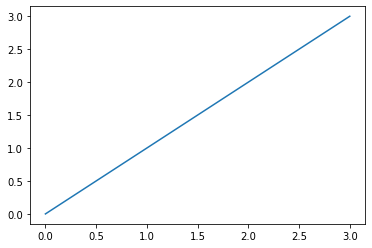

In [199]:
def create_model(optimizer='Adam',
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

Alternative: use qsar fingerprints: http://www.qsar4u.com/files/qsar_rdkit_tutorial/qsar-rdkit.html

Alternative to consider: https://pubs.acs.org/doi/10.1021/acs.jcim.7b00616

Why the morgan fingerprint? The litterature does not seem to agree but they seem to lean towards that fingerprint: http://practicalcheminformatics.blogspot.com/2020/03/benchmarking-one-molecular-fingerprint.html

Iterations:
1. Tried to compute morgan fingerprint and take that output to compute a ridge regression. This would have been the simplest and most naive iteration. Initially a failure, I ended up being able to fine tune it more or less. Due to the high cost of the computations I did not fine-tune the hyperparameters too much.
2. 